# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [89]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [90]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_max = 256
valor_min = 0
valores_color = 3
num_colores = 100
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))

## SOM Setup
#### Variables definidas por el alumno

In [91]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 40 #  HAY QUE TOCARLO
periodo = 300 # HAY QUE TOCARLO
learning_rate = 0.3 # HAY QUE TOCARLO
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [92]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = valores_color
num_datos = num_colores

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario_inicial = int(lado_mapa/2)

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = datos / 255
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random((lado_mapa,lado_mapa,valores_color))

#### Funciones para entrenar/clasificar

In [93]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
   rows = len(m_pesos)
   columns = len(m_pesos[0])
   vectorPesos =  []
   ganadora = 2000
   for x in range(rows):
      for y in range(columns):
         for z in range(m):
            vectorPesos.append(m_pesos[x][y][z])
         dist = np.linalg.norm(np.array(vectorPesos) - np.array(patron_entrada))
         if dist < ganadora:
            ganadora = dist
            Bmu = vectorPesos
            BmuIndex = [x,y]
         vectorPesos = []
   return Bmu , BmuIndex

In [94]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
   learning_rate = lr_inicial * (1 - i/n_iteraciones)
   return learning_rate

In [95]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   if i == 0: # Si no da error de division by zero
      return 1
   vecindario = 1 + vecindario_inicial * (1 - i/n_iteraciones)
   return int(vecindario)

In [96]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

In [97]:
#Funcion Ajuste de matriz de pesos
def ajustarPesos(IndexN , color , learning_rate , matriz_pesos, vecindario):
    matriz_pesos[IndexN[0],IndexN[1]] += learning_rate * (color - matriz_pesos[IndexN[0],IndexN[1]]) # Cambiamos la ganadora
    vectorBMU = [IndexN[0],IndexN[1]]
    # AHORA EL VECINADRIO LO CAMBIAMOS
    for i in range(max(0, IndexN[0]-vecindario), min(len(matriz_pesos), IndexN[0]+vecindario)): # NO SE SALE DE LIMITES
        for j in range(max(0, IndexN[1]-vecindario), min(len(matriz_pesos[0]), IndexN[1]+vecindario)): # NO SE SALE DE LIMITES
            vectorNeurona = [i,j]
            dist_euc = np.linalg.norm(np.array(vectorBMU) - np.array(vectorNeurona)) # Distancia euclidea
            """
            Si la distancia ≤ vecindario, calcula la amortiguación de esa neurona y actualiza el 
            vector de pesos de la neurona usando la fórmula
            """
            if(dist_euc <= vecindario):
                dist_decay = decay(dist_euc,vecindario) # AMORTIGUACIÓN
                matriz_pesos[i,j] += learning_rate * dist_decay * (color - matriz_pesos[i,j])   
    return matriz_pesos


#### Funciones para dibujar la salida de la red

In [98]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

## SOM Entrenamiento

In [99]:
def shuffle():
    rng = np.random.default_rng()
    datos = datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))
    datos = datos/255
    datos = np.transpose(datos)
    datos = rng.permuted(datos, out=datos) # MOvemos los datos pa que no se acostumbre
    return datos

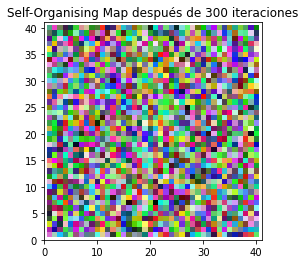

0 Iteraciones hechas
100 Iteraciones hechas
200 Iteraciones hechas
[[[0.33884279 0.26600006 0.76559621]
  [0.26506526 0.39129337 0.7417766 ]
  [0.26682315 0.39622689 0.74654119]
  ...
  [0.70566061 0.85699102 0.46679427]
  [0.70733901 0.85684604 0.4665704 ]
  [0.72390983 0.8616813  0.46026524]]

 [[0.25210589 0.27144188 0.73867235]
  [0.25879275 0.38199277 0.74256415]
  [0.2583642  0.39717876 0.73494968]
  ...
  [0.69864093 0.85566988 0.46492643]
  [0.70490001 0.85382771 0.47025103]
  [0.72545661 0.84538302 0.52133556]]

 [[0.25516621 0.3801908  0.73102722]
  [0.25544715 0.38733112 0.73312545]
  [0.25472551 0.40027109 0.7277008 ]
  ...
  [0.69148414 0.83423887 0.52321887]
  [0.6983162  0.83625678 0.52163794]
  [0.70588547 0.83663468 0.52533524]]

 ...

 [[0.24406301 0.24781045 0.2347667 ]
  [0.36967926 0.26926348 0.21649481]
  [0.3950097  0.28167815 0.21065996]
  ...
  [0.77608429 0.38459862 0.51032481]
  [0.79746927 0.38427054 0.55293432]
  [0.80331701 0.38514879 0.55978931]]

 [[0.20

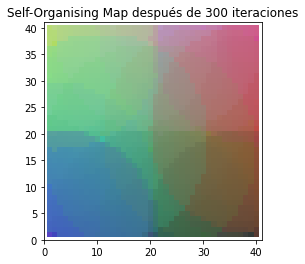

In [100]:
# Entrena la red con el dataset de entrenamiento
pintar_mapa(matriz_pesos)
matriz_antes = matriz_pesos
vecindario = vecindario_inicial
for x in range(periodo):
    if x % 100 == 0:
        print(x, "Iteraciones hechas")
    datos = shuffle() # Generamos nuevo set de 100 datos en cada iteración para que no se acosutmbre
    for color in datos:
        Bmu , BmuIndex = calcular_bmu(color,matriz_pesos,valores_color)
        matriz_pesos = ajustarPesos(BmuIndex , color , learning_rate , matriz_pesos, vecindario).copy()
        learning_rate = variacion_learning_rate(learning_rate,x,periodo)
        vecindario = variacion_vecindario(vecindario_inicial,x,periodo)
print(matriz_pesos)
pintar_mapa(matriz_pesos)

## SOM Clasificación

In [101]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada



## SOM Prueba

In [102]:
# Clasifica nuevos patrones

